In [1]:
# importing the required libraries
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the 'Value' type
from utils import Value, MLP
from utils import PalindromeDataset, PalindromeDatasetFull

In [3]:
# Example computation
a = Value(1)
b = Value(2)
c = Value(3)
d = Value(4)

e = a*b + c*d
f = e/2.

# checking final values and initial grads (should be zero)
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

# backprop
f.backward()

# checking final grads
print(e, f, a.grad, b.grad, c.grad, d.grad, e.grad, f.grad)

Value(data=14) Value(data=7.0) 0 0 0 0 0 0
Value(data=14) Value(data=7.0) 1.0 0.5 2.0 1.5 0.5 1


In [4]:
# showing the training of a simple NN, with some data
# input dim=3, output dim=1, atchitecture : NN with 4 layers : 3,4,4,1 neurons resp
from utils import MLP

# testing the MLP 
xs = [
    [2,3,-1],
    [3,-1,0.5],
    [0.5,1,1],
    [1,1,-1]
]
ys = [1,-1,-1,1] # labels
losslog = []
a = MLP(3, [4,4,1])
for step in range(200) : # 200 epochs
    # forward pass
    ypred = [a(x)[0] for x in xs]
    loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    
    # update 
    for w in a.parameters() :
        w.data -= 0.005 * w.grad # standard SGD for now

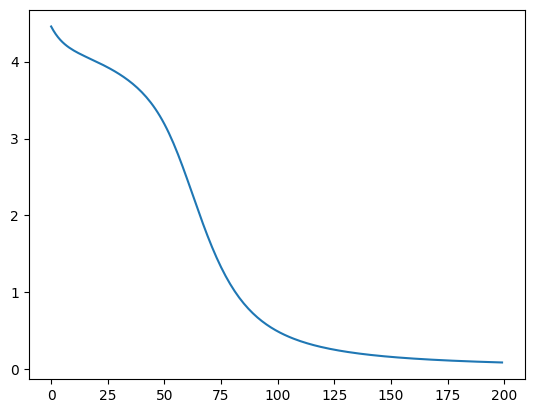

In [5]:
plt.plot(losslog)
plt.show()

In [6]:
# checking performance on the four data points
# should be close to ys=[1,-1,-1,1]
[a(x)[0] for x in xs]

[Value(data=0.8442281397216626),
 Value(data=-0.8781425781240726),
 Value(data=-0.8376995370875562),
 Value(data=0.8563240746183143)]

In [26]:
datasetMaker = PalindromeDataset(10)
dataset = datasetMaker.generate_dataset(30, 30)

In [27]:
len(dataset)

60

In [ ]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

In [29]:
# showing the training of a simple NN, with some data
# input dim=10, output dim=1, atchitecture : NN with 1 hidden layers : 4 with neurons
from utils import MLP
from tqdm.notebook import tqdm

losslog = []
a = MLP(10, [4, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 1000

xs, ys = convert_to_form(dataset)

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()

    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.05 * w.grad # standard SGD for now

  0%|          | 0/1000 [00:00<?, ?it/s]

epoch 0 loss 42.1785
epoch 50 loss 37.5908
epoch 100 loss 36.2446
epoch 150 loss 23.2981
epoch 200 loss 13.5889
epoch 250 loss 7.8136
epoch 300 loss 4.3049
epoch 350 loss 2.8982
epoch 400 loss 2.1321
epoch 450 loss 1.6620
epoch 500 loss 1.3502
epoch 550 loss 1.1310
epoch 600 loss 0.9696
epoch 650 loss 0.8465
epoch 700 loss 0.7497
epoch 750 loss 0.6719
epoch 800 loss 0.6081
epoch 850 loss 0.5549
epoch 900 loss 0.5099
epoch 950 loss 0.4714


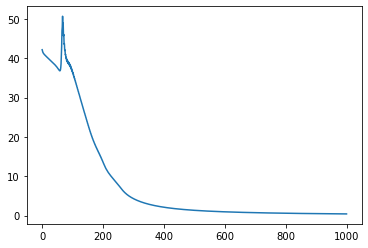

In [30]:
plt.plot(losslog)
plt.show()

In [31]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 1.0000 f1 1.0000
Threshold 0.2 accuracy 1.0000 f1 1.0000
Threshold 0.3 accuracy 1.0000 f1 1.0000
Threshold 0.4 accuracy 1.0000 f1 1.0000
Threshold 0.5 accuracy 1.0000 f1 1.0000
Threshold 0.6 accuracy 1.0000 f1 1.0000
Threshold 0.7 accuracy 1.0000 f1 1.0000
Threshold 0.8 accuracy 1.0000 f1 1.0000
Threshold 0.9 accuracy 1.0000 f1 1.0000


In [35]:
max(predictions), min(predictions)

(0.9999923651139505, 0.0010043010391068488)

In [45]:
from sklearn.metrics import confusion_matrix

# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.1 0.548828125 0.12167300265494659
0.2 0.6005859375 0.13530655264395766
0.3 0.6279296875 0.14382022337785635
0.4 0.6494140625 0.15130023500092218
0.5 0.66796875 0.15841584011763557
0.6 0.69140625 0.16842105108033242
0.7 0.7109375 0.17777777614814816
0.8 0.7412109375 0.19452887361203242
0.9 0.796875 0.23529411555363325


array([[784, 208],
       [  0,  32]], dtype=int64)

In [18]:
max(predictions), min(predictions)

(0.9996391784002346, 2.1230088668802731e-07)

Training on full dataset

In [3]:
datasetMaker = PalindromeDatasetFull(10) 
dataset = datasetMaker.generate_dataset()
len(dataset)

1024

In [4]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

  0%|          | 0/250 [00:00<?, ?it/s]

epoch 0 loss 1186.8409
epoch 50 loss 722.7990
epoch 100 loss 691.4069
epoch 150 loss 645.0974
epoch 200 loss 640.1824


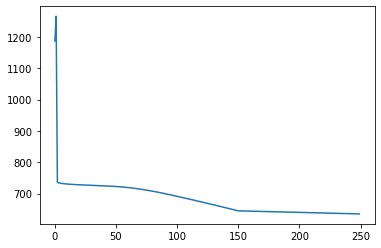

In [5]:
from tqdm.notebook import tqdm
import random

random.shuffle(dataset)
xs, ys = convert_to_form(dataset)

losslog = []
a = MLP(10, [2, 1])
weight = 10. # added weight to try and counter the class imbalance
nepochs = 250

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        lr = 0.005 if step<150 else 0.0005
        w.data -= lr * w.grad # standard SGD for now

plt.plot(losslog)
plt.show()

In [6]:
predictions = np.array([a(k)[0].data for k in xs])
max(predictions), min(predictions)

(0.4657726004377856, 0.009354285268785316)

In [7]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,6) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.2637 f1 0.0782
Threshold 0.2 accuracy 0.3682 f1 0.0900
Threshold 0.3 accuracy 0.7607 f1 0.1026
Threshold 0.4 accuracy 0.9482 f1 0.1587
Threshold 0.5 accuracy 0.9688 f1 0.0000


In [33]:
from sklearn.metrics import confusion_matrix

preds = np.array(1*(predictions > 0.4))
confusion_matrix(ys, preds)

array([[966,  26],
       [ 27,   5]], dtype=int64)

In [34]:
[(x,y) for x,y in zip(predictions[preds != ys], np.array(ys)[preds != ys])]

[(0.25680867716853484, 1),
 (0.4098519763843962, 0),
 (0.42221481458020826, 0),
 (0.33044555167586337, 1),
 (0.40425141707868173, 0),
 (0.24959611014851937, 1),
 (0.25239433596257815, 1),
 (0.26089910443575887, 1),
 (0.4275251119542925, 0),
 (0.43703841021591333, 0),
 (0.2592502697451528, 1),
 (0.40870100957268585, 0),
 (0.25442755364156633, 1),
 (0.44135910736583644, 0),
 (0.43919822407476683, 0),
 (0.2859942840239157, 1),
 (0.37569507524432955, 1),
 (0.24352223955806543, 1),
 (0.45648961030787555, 0),
 (0.29389912699705567, 1),
 (0.415874409756452, 0),
 (0.42402970193448886, 0),
 (0.41493853135474745, 0),
 (0.31975289184920486, 1),
 (0.25014597403216215, 1),
 (0.3422344492717088, 1),
 (0.40267238905061165, 0),
 (0.42351330430094464, 0),
 (0.35275489127504683, 1),
 (0.4011248546673852, 0),
 (0.4517447102931649, 0),
 (0.38753846468888015, 1),
 (0.4657726004377856, 0),
 (0.4011044258228207, 0),
 (0.3299551577868459, 1),
 (0.2745642320300912, 1),
 (0.40477633024157805, 0),
 (0.4238239143

Training on Full (balanced) Dataset

In [3]:
datasetMaker = PalindromeDatasetFull(10, True) # taking all palindromes, and en equal number of non-palindromes
dataset = datasetMaker.generate_dataset()
len(dataset)

64

In [6]:
def convert_to_form(dataset):
    xs = []
    ys = []
    for x, y in dataset:
        xs.append([int(k) for k in list(x)])
        ys.append(y)
    return xs, ys

  0%|          | 0/750 [00:00<?, ?it/s]

epoch 0 loss 42.8245
epoch 50 loss 6.4867
epoch 100 loss 4.4064
epoch 150 loss 3.7196
epoch 200 loss 3.4016
epoch 250 loss 3.2083
epoch 300 loss 3.0491
epoch 350 loss 2.8730
epoch 400 loss 2.6547
epoch 450 loss 2.3971
epoch 500 loss 2.1168
epoch 550 loss 1.8303
epoch 600 loss 1.5502
epoch 650 loss 1.2886
epoch 700 loss 1.0603


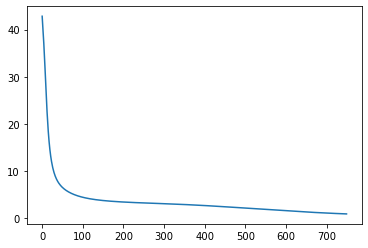

In [14]:
from tqdm.notebook import tqdm
import random

random.shuffle(dataset)
xs, ys = convert_to_form(dataset)

losslog = []
a = MLP(10, [2, 1])
weight = 1. # added weight to try and counter the class imbalance
nepochs = 750

for step in tqdm(range(nepochs)) : 
    # forward pass
    ypred = [a(x)[0] for x in xs]
    # loss = sum((ypred-ytrue)**2 for ytrue, ypred in zip(ys, ypred)) # MSE
    loss = sum(-weight*ytrue*ypred.log()-(1-ytrue)*(1-ypred).log() for ytrue, ypred in zip(ys, ypred)) # BCE
    losslog.append(loss.data)
    
    a.zero_grad() # taken from Module class
    loss.backward()
    if step%50==0 : tqdm.write(f'epoch {step} loss {loss.data:.4f}')
    
    # update 
    for w in a.parameters() :
        w.data -= 0.05 * w.grad # standard SGD for now

plt.plot(losslog)
plt.show()

In [16]:
predictions = np.array([a(k)[0].data for k in xs])
max(predictions), min(predictions)

(0.9973993700014929, 2.725765208556592e-06)

In [17]:
eps = 1e-8
predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    thresh = i/10
    preds = np.array(1*(predictions > thresh))

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    # true_pos = sum(np.array(ys)==1 and preds==1)
    # true_neg = sum(np.array(ys)==0 and preds==0)
    # false_pos = sum(np.array(ys)==0 and preds==1)
    # false_neg = sum(np.array(ys)==1 and preds==0)

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)
    print(f'Threshold {thresh:.1f} accuracy {acc:.4f} f1 {f1:.4f}')

Threshold 0.1 accuracy 0.9688 f1 0.9697
Threshold 0.2 accuracy 0.9844 f1 0.9846
Threshold 0.3 accuracy 1.0000 f1 1.0000
Threshold 0.4 accuracy 1.0000 f1 1.0000
Threshold 0.5 accuracy 1.0000 f1 1.0000
Threshold 0.6 accuracy 1.0000 f1 1.0000
Threshold 0.7 accuracy 1.0000 f1 1.0000
Threshold 0.8 accuracy 1.0000 f1 1.0000
Threshold 0.9 accuracy 0.9688 f1 0.9677


In [38]:
sum(ys[-32:]), sum(ys[:32]), len(ys)

(1, 1, 1024)

In [29]:
[(x,y) for x,y in zip(ys[-10:], predictions[-10:])]

[(0, 0.9974219748470972),
 (0, 0.9974156757827071),
 (0, 0.997424877340942),
 (0, 0.997422448300127),
 (0, 0.9974226079930143),
 (0, 0.9974170665937605),
 (0, 0.9974218390235915),
 (0, 0.9974153837200147),
 (0, 0.997415781063096),
 (1, 0.9973993700014929)]

In [37]:
from sklearn.metrics import confusion_matrix

# testing on full dataset
test_datasetMaker = PalindromeDatasetFull(10)
test_dataset = test_datasetMaker.generate_dataset()

xs, ys = convert_to_form(test_dataset)

predictions = np.array([a(k)[0].data for k in xs])

for i in range(1,10) :
    preds = 1*(predictions > i/10)

    true_pos = sum([int(a==1 and b==1) for a,b in zip(preds, ys)])
    true_neg = sum([int(a==0 and b==0) for a,b in zip(preds, ys)])
    false_pos = sum([int(a==1 and b==0) for a,b in zip(preds, ys)])
    false_neg = sum([int(a==0 and b==1) for a,b in zip(preds, ys)])

    num_correct = true_neg + true_pos
    prec = true_pos / (true_pos + false_pos + eps)
    recall = true_pos / (true_pos + false_neg + eps)
    f1 = 2*prec*recall / (prec + recall + eps)
    acc = num_correct / len(ys)

    print(i/10, acc, f1)

confusion_matrix(ys, preds)

0.1 0.16796875 0.06986899495738069
0.2 0.2001953125 0.07248018050027638
0.3 0.2236328125 0.07450523793056064
0.4 0.228515625 0.07494145126754385
0.5 0.2294921875 0.0750293075996586
0.6 0.236328125 0.0756501174736348
0.7 0.2509765625 0.07701564306029446
0.8 0.263671875 0.07823960804825414
0.9 0.3369140625 0.08119079754545239


array([[315, 677],
       [  2,  30]], dtype=int64)

In [13]:
max(predictions), min(predictions)

(0.9997860711532294, 1.081999663284354e-06)